In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return an integer (GPU index)
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

In [ ]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True

CUDA


In [2]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)


In [ ]:
class PINN():
    def __init__(self, X, u, layers, bc):

        # data 
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.y = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 2:3], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)

        # deep neural network
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer = torch.optim.Adam(self.dnn.parameters(), lr=0.01)


(3, 1000)
(3, 100)
(3, 100)
(3, 1200)


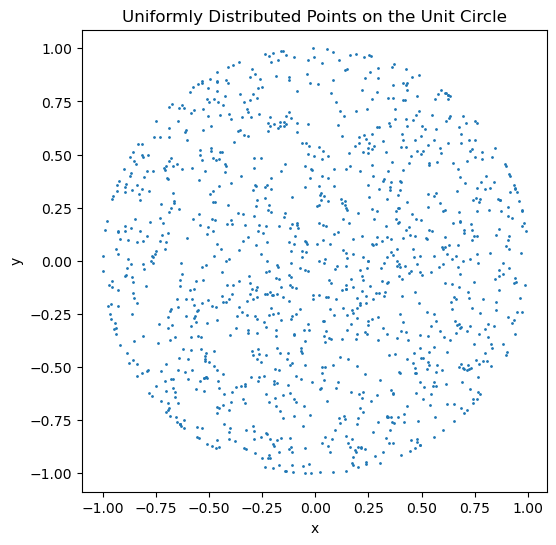

In [34]:
np.random.seed(1234)

def boundary_points(n_points):
    angles = np.random.uniform(0, 2 * np.pi, n_points)

    x = np.cos(angles)
    y = np.sin(angles)
    t = np.random.uniform(0, 1, n_points)

    return np.array([x, y, t])

def domain_points(n_points):
    angles = np.random.uniform(0, 2 * np.pi, n_points)
    radii = np.sqrt(np.random.uniform(0, 1, n_points))
    t = np.random.uniform(0, 1, n_points)
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)

    return np.array([x, y, t])

def initial_points(n_points):
    angles = np.random.uniform(0, 2 * np.pi, n_points)
    radii = np.sqrt(np.random.uniform(0, 1, n_points))
    t = np.zeros(n_points)
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)

    return np.array([x, y, t])

dp = domain_points(1000)
bc = boundary_points(100)
ic = initial_points(100)
print(dp.shape)
print(bc.shape)
print(ic.shape)

combined = np.hstack((dp, bc, ic))
print(combined.shape)

# Plot the points to visualize
plt.figure(figsize=(6, 6))
plt.scatter(combined[0], combined[1], s=1)
plt.axis('equal')
plt.title('Uniformly Distributed Points on the Unit Circle')
plt.xlabel('x')
plt.ylabel('y')
plt.show()